In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import system libs
import os
import itertools
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Generate data paths with labels
data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_data = pd.concat([Fseries, Lseries], axis= 1)
train_data.head()

,filepaths,labels
0,/kaggle/input/intel-image-classification/seg_t...,mountain
1,/kaggle/input/intel-image-classification/seg_t...,mountain
2,/kaggle/input/intel-image-classification/seg_t...,mountain
3,/kaggle/input/intel-image-classification/seg_t...,mountain
4,/kaggle/input/intel-image-classification/seg_t...,mountain


In [3]:
# Generate data paths with labels
data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_data = pd.concat([Fseries, Lseries], axis= 1)
test_data.head()

,filepaths,labels
0,/kaggle/input/intel-image-classification/seg_t...,mountain
1,/kaggle/input/intel-image-classification/seg_t...,mountain
2,/kaggle/input/intel-image-classification/seg_t...,mountain
3,/kaggle/input/intel-image-classification/seg_t...,mountain
4,/kaggle/input/intel-image-classification/seg_t...,mountain


In [4]:
df = pd.concat([train_data, test_data])

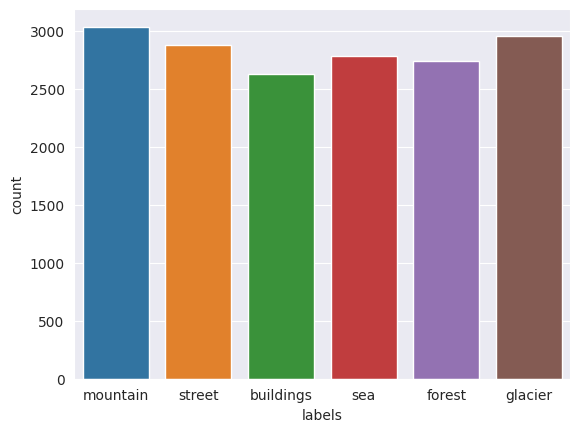

In [5]:
sns.countplot(data=df, x='labels')
plt.show()

In [6]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, random_state= 42,stratify=strat)

In [7]:
# crobed image size
batch_size = 12
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 13627 validated image filenames belonging to 6 classes.
Found 3407 validated image filenames belonging to 6 classes.


In [8]:
classes = list(train_gen.class_indices.keys())
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

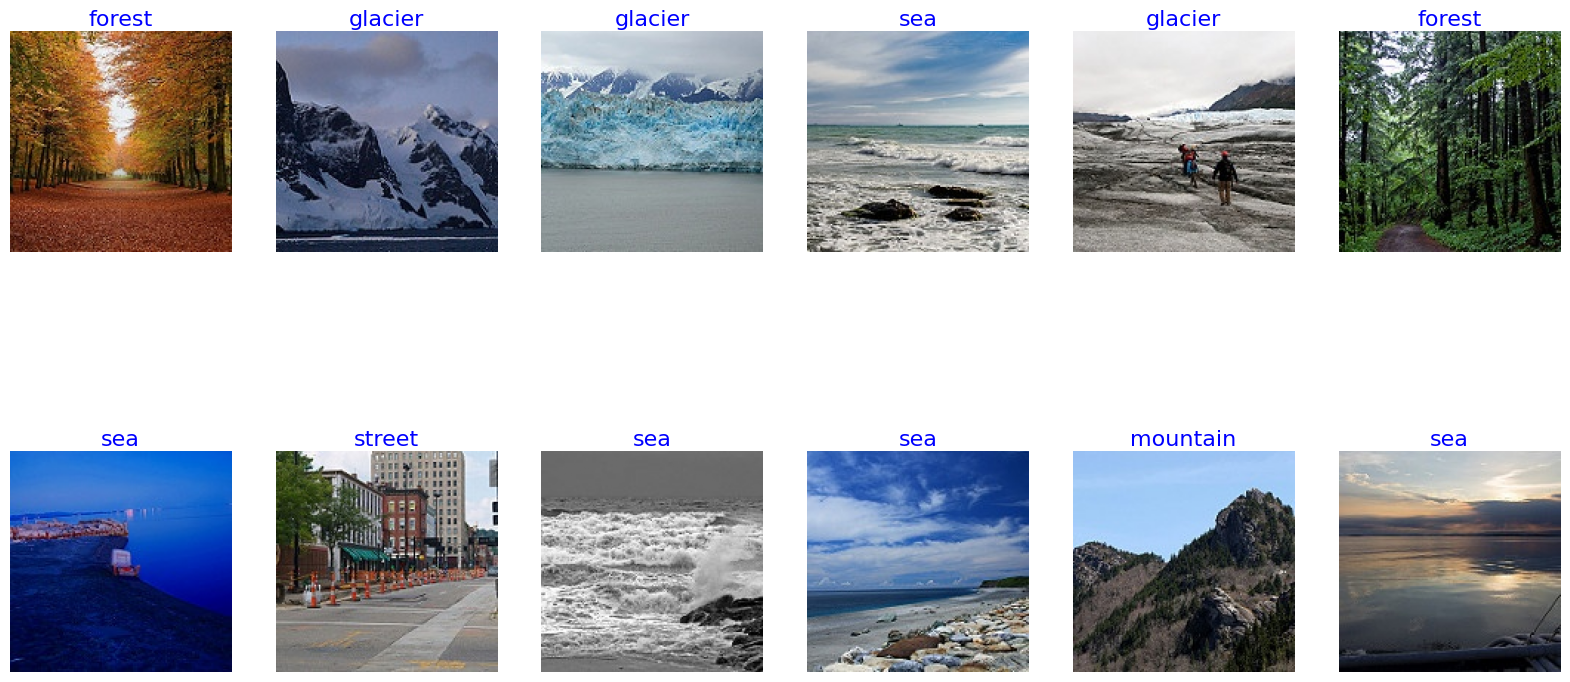

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(12):
    plt.subplot(2, 6, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 16,pad=4)
    plt.axis('off')
plt.show()

In [10]:
# Create Model Structure
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

def make_model(learning_rate = 0.001 , size_inner=256, droprate=0.5):
    
    base_model = keras.applications.efficientnet_v2.EfficientNetV2B3(
        include_top= False,
        weights= "imagenet",
        input_shape= img_shape,
        pooling= 'max')
    
    base_model.trainable = False

    #########################################
    
    inputs = keras.Input(shape=img_shape)
    base = base_model(inputs, training=False)
    batch = keras.layers.BatchNormalization(axis= -1,
                                            momentum= 0.99,
                                            epsilon= 0.001)(base)
    inner = keras.layers.Dense(size_inner,
                               kernel_regularizer= regularizers.l2(0.016),
                               activity_regularizer= regularizers.l1(0.006),
                               bias_regularizer= regularizers.l1(0.006),
                               activation='relu')(batch)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(class_count, activation= 'softmax')(drop)
    model = keras.Model(inputs, outputs)
    
     #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

model = make_model() # For testing the model function
model.summary()

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,331,780 (50.86 MB)

 Trainable params: 398,086 (1.52 MB)

 Non-trainable params: 12,933,694 (49.34 MB)

In [11]:
# scores = {}

# for lr in [0.0001, 0.001, 0.01, 0.1]:
#     print(lr)

#     model = make_model(learning_rate=lr)
#     history = model.fit(x= train_gen, epochs=20, validation_data= test_gen)
#     scores[lr] = history.history

#     print()
#     print()

In [12]:
# del scores[0.1]
# del scores[0.01]

In [13]:
# for lr, hist in scores.items():
#     #plt.plot(hist['accuracy'], label=('train=%s' % lr))
#     plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

# plt.xticks(np.arange(20))
# plt.legend()

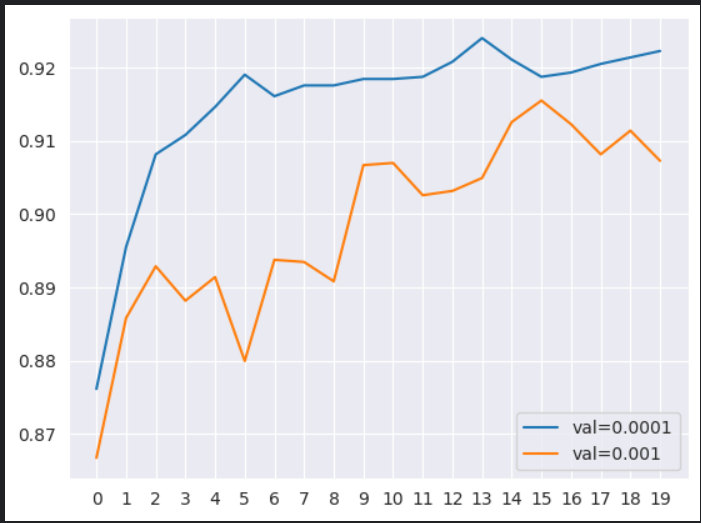

In [14]:
# learning_rate = 0.0001

# scores = {}

# for size in [128,256,512,1024]:
#     print(size)

#     model = make_model(learning_rate=learning_rate, size_inner=size)
#     history = model.fit(x= train_gen, epochs=20, validation_data= test_gen)
#     scores[size] = history.history

#     print()
#     print()

In [15]:
# for size, hist in scores.items():
#     plt.plot(hist['val_accuracy'], label=('val=%s' % size))

# plt.xticks(np.arange(20))
# plt.yticks([0.82, 0.86,0.88,0.90,0.91,0.92])
# plt.legend()

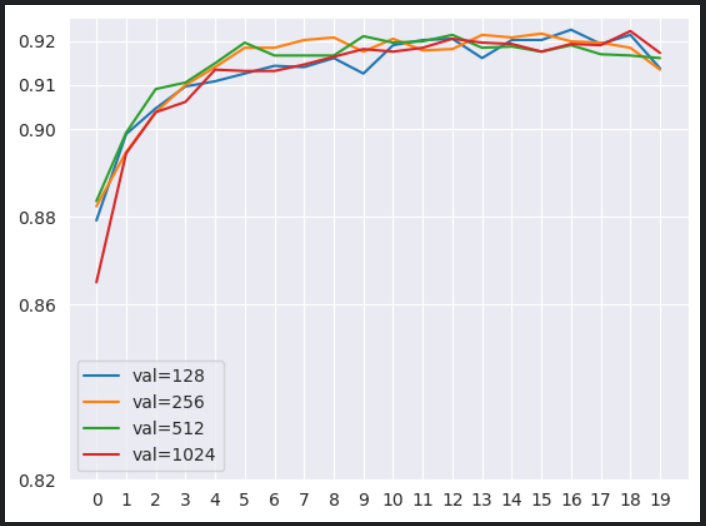

In [16]:
# learning_rate = 0.0001
# size = 256

# scores = {}

# for droprate in [0.0, 0.2, 0.5, 0.8]:
#     print(droprate)

#     model = make_model(
#         learning_rate=learning_rate,
#         size_inner=size,
#         droprate=droprate
#     )

#     history = model.fit(x= train_gen, epochs=30, validation_data= test_gen)
#     scores[droprate] = history.history

#     print()
#     print()

In [17]:
# for droprate, hist in scores.items():
#     plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

# # plt.ylim(0.825, 0.95)
# plt.legend()

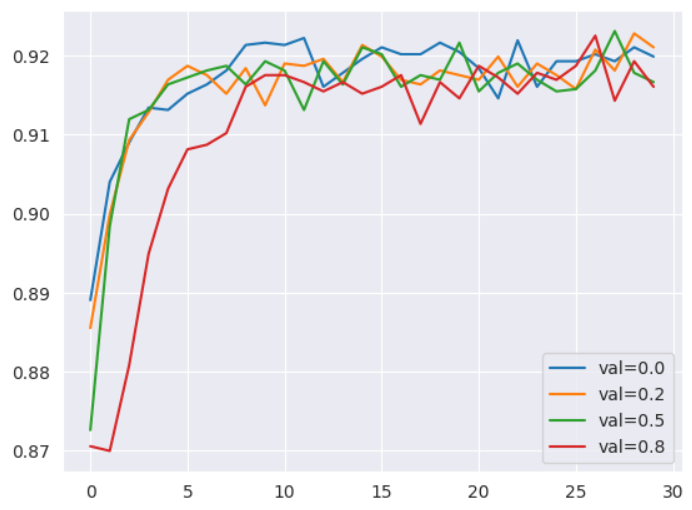

In [18]:
# hist = scores[0.0]
# plt.plot(hist['val_accuracy'], label=0.0)

# hist = scores[0.2]
# plt.plot(hist['val_accuracy'], label=0.2)

# hist = scores[0.5]
# plt.plot(hist['val_accuracy'], label=0.5)

# plt.legend()
# #plt.plot(hist['accuracy'], label=('val=%s' % droprate))

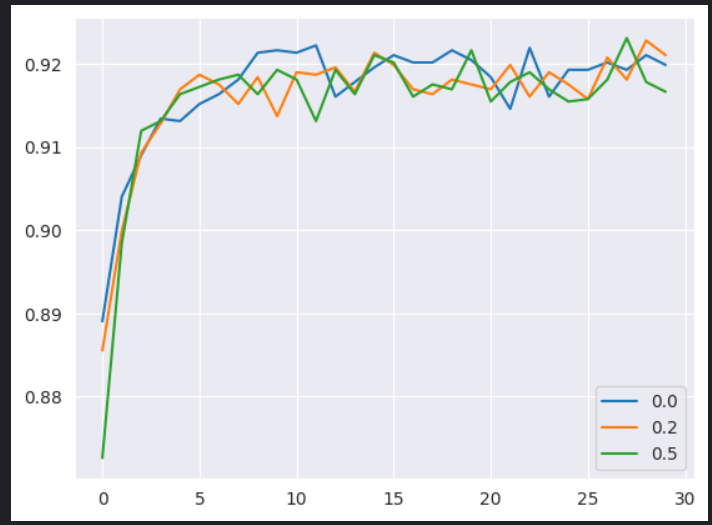

In [19]:
checkpoint = ModelCheckpoint(
    'EfficientNetV2B3_v2_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
    )

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [20]:
learning_rate = 0.0001
size = 128
droprate = 0

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(x= train_gen,
                    epochs=30,
                    validation_data= test_gen,
                    callbacks=[checkpoint,early_stopping])

print()
print()

Epoch 1/30


I0000 00:00:1726584945.066576      70 service.cc:145] XLA service 0x7ee010004170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726584945.066665      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726584945.066670      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1136 ━━━━━━━━━━━━━━━━━━━━ 1:00 53ms/step - accuracy: 0.1806 - loss: 11.2563   

I0000 00:00:1726584991.400468      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1136/1136 ━━━━━━━━━━━━━━━━━━━━ 220s 135ms/step - accuracy: 0.6898 - loss: 7.8321 - val_accuracy: 0.8885 - val_loss: 3.6798
Epoch 2/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.8646 - loss: 3.2975 - val_accuracy: 0.9043 - val_loss: 2.1149
Epoch 3/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.8781 - loss: 1.9230 - val_accuracy: 0.9131 - val_loss: 1.2509
Epoch 4/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.8898 - loss: 1.1958 - val_accuracy: 0.9117 - val_loss: 0.8842
Epoch 5/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.8924 - loss: 0.9054 - val_accuracy: 0.9140 - val_loss: 0.7565
Epoch 6/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9021 - loss: 0.7980 - val_accuracy: 0.9131 - val_loss: 0.7027
Epoch 7/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9029 - loss: 0.7428 - val_accuracy: 0.9178 - val_loss: 0.6616
Epoch 8/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.9095 - loss: 0.

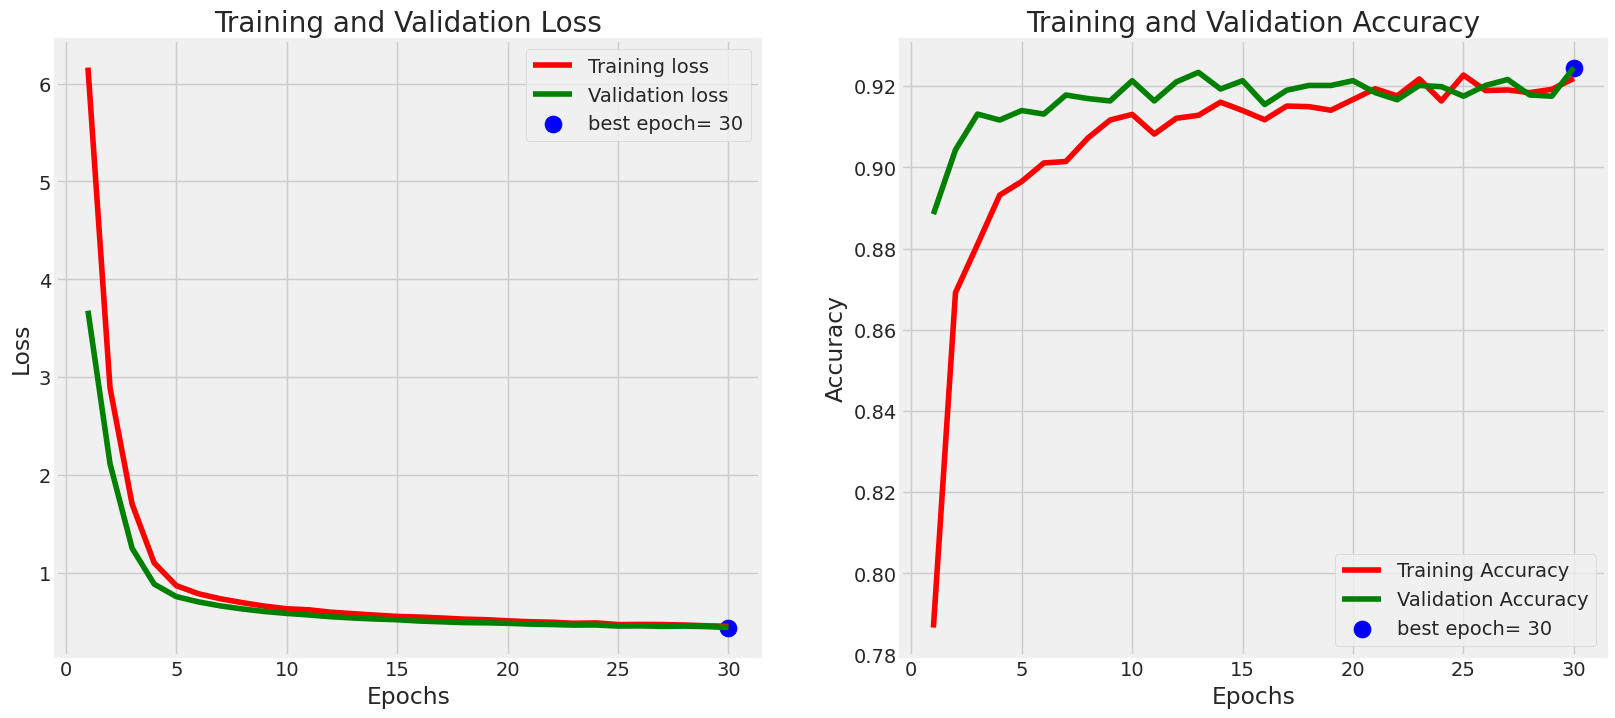

In [21]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [22]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1136/1136 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9530 - loss: 0.3651
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9258 - loss: 0.4492
Train Loss:  0.36475634574890137
Train Accuracy:  0.9534747004508972
--------------------
Test Loss:  0.4398937225341797
Test Accuracy:  0.9245670437812805


In [23]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

284/284 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step


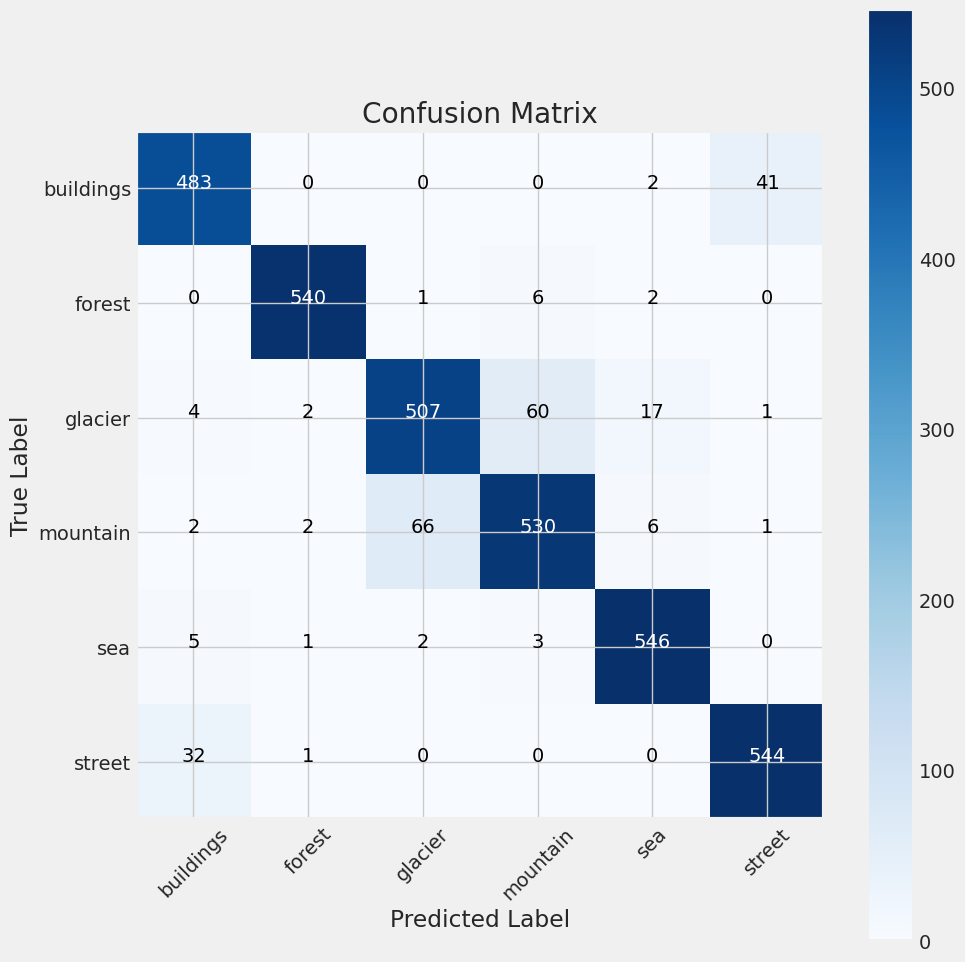

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       526
      forest       0.99      0.98      0.99       549
     glacier       0.88      0.86      0.87       591
    mountain       0.88      0.87      0.88       607
         sea       0.95      0.98      0.97       557
      street       0.93      0.94      0.93       577

    accuracy                           0.92      3407
   macro avg       0.93      0.93      0.93      3407
weighted avg       0.92      0.92      0.92      3407

